In [1]:
# The version with separate transforms and some other changes.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable


In [2]:
TRAIN_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\sameSizeLessQTrain"
VALID_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\valid"
TEST_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\test"
COLOR_CODES = r"E:\THIRD YEAR\Datasets\deepglobe\class_dict.csv"

# Transformation for images (including resizing and converting to tensor)
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # this works fine for images
])

# Transformation for masks (using nearest neighbor interpolation for resize)
mask_transform = transforms.Compose([
    transforms.ToTensor(),  # ensure mask remains a tensor with integer values
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)  # use nearest neighbor for masks
])

In [3]:
df = pd.read_csv(COLOR_CODES)
label_map = {}
for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
label_map

# label_map = {
#     0: [0, 255, 255],  # class1
#     1: [255, 255, 0],  # class2
#     2: [255, 0, 255],  # class3
#     3: [0, 255, 0],    # class4
#     4: [0, 0, 255],    # class5
#     5: [255, 255, 255],# class6
#     6: [0, 0, 0]       # class7
# }
# label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [4]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg')])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png')])
        
        # Debug prints
        print(f'Number of images: {len(self.images_name)}')
        print(f'Number of masks: {len(self.targets_name)}')

    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        if idx >= len(self.images_name) or idx >= len(self.targets_name):
            raise IndexError(f'Index {idx} out of range. Lengths are {len(self.images_name)} for images and {len(self.targets_name)} for masks.')
        
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask
    
    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.int64)  # Ensure mask is in int64 for class indices

In [5]:
# TESTING - seems to be working fine
mask_path = 'E:\\THIRD YEAR\\Datasets\\deepglobe\\sameSizeLessQTrain\\27460_mask.png'
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# Flatten the mask and get unique colors
unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

# Check if each color is in the label_map
for color in unique_colors:
    if not any(np.array_equal(color, np.array(c)) for c in label_map.values()):
        print(f"Color {color} is not in the label_map")

In [6]:
"""img, mask, bla = Segmentation_Dataset(TRAIN_DIR, label_map).__getitem__(0)
print(bla)
sample = [img, mask]
for i in range(len(sample)):
    plt.subplot(1, 2, i+1)
    plt.imshow(sample[i])
    plt.axis('off')
plt.show()"""

"img, mask, bla = Segmentation_Dataset(TRAIN_DIR, label_map).__getitem__(0)\nprint(bla)\nsample = [img, mask]\nfor i in range(len(sample)):\n    plt.subplot(1, 2, i+1)\n    plt.imshow(sample[i])\n    plt.axis('off')\nplt.show()"

In [7]:
# This residual structure is inspired by ResNet,

class ResidualBlock(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        self.skip = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

    def forward(self, x):
        conv = self.conv(x)
        skip = self.skip(x)

        plus = conv + skip
        return plus

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = ResidualBlock(3, 64)
        self.dconv_down2 = ResidualBlock(64, 128)
        self.dconv_down3 = ResidualBlock(128, 256)
        self.dconv_down4 = ResidualBlock(256,512)
        self.bottleneck = ResidualBlock(512, 1024)        

        self.maxpool = nn.MaxPool2d(2)

        self.dconv1 =  nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)        
        self.dconv2 =  nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv3 =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv4 =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dconv_up4 = ResidualBlock(1024, 512) 
        self.dconv_up3 = ResidualBlock(512, 256)
        self.dconv_up2 = ResidualBlock(256, 128)
        self.dconv_up1 = ResidualBlock(128, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        # encoder
        conv1 = self.dconv_down1(x)
        x1 = self.maxpool(conv1) 

        conv2 = self.dconv_down2(x1)
        x2 = self.maxpool(conv2) 
        
        conv3 = self.dconv_down3(x2)
        x3 = self.maxpool(conv3) 

        conv4 = self.dconv_down4(x3)
        x4 = self.maxpool(conv4)         

        x5 = self.bottleneck(x4) 


        x = self.dconv1(x5)        
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)

        x = self.dconv2(x)        
        x = torch.cat([x, conv3], dim=1)       
        x = self.dconv_up3(x)

        x = self.dconv3(x)        
        x = torch.cat([x, conv2], dim=1)   
        x = self.dconv_up2(x)

        x = self.dconv4(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        
        seg = self.conv_last(x)

        return seg


In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.gamma = gamma
        self.alpha = alpha
        
        if isinstance(alpha, (float, int, torch.LongTensor)): 
            self.alpha = torch.Tensor([alpha, 1 - alpha]).float()
        if isinstance(alpha, list): 
            self.alpha = torch.Tensor(alpha).float()

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1).long()  # Ensure target is of type int64

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == "none":
            return loss
        elif self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()


In [9]:
import numpy as np
import cv2

reverse_label_map = {tuple(v): k for k, v in label_map.items()}

mask_path = 'E:\\THIRD YEAR\\Datasets\\deepglobe\\sameSizeLessQTrain\\27460_mask.png'
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# Get unique colors
unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

# Check if each color is in the label_map
for color in unique_colors:
    if not any(np.array_equal(color, np.array(c)) for c in label_map.values()):
        print(f"Color {color} is not in the label_map")
    else:
        print(f"color {color} seems to be there in the label map")


# Print with class names
for color, index in reverse_label_map.items():
    class_name = class_names[index] if index < len(class_names) else "Unknown"
    print(f"Color {color} maps to class {class_name} ({index})")

color [  0 255   0] seems to be there in the label map
color [  0 255 255] seems to be there in the label map
color [255   0 255] seems to be there in the label map
color [255 255   0] seems to be there in the label map


NameError: name 'class_names' is not defined

In [32]:
# Alright lets do it again(debugging)

import numpy as np
import cv2
import os
import pandas as pd
from collections import defaultdict

# Define paths
MASK_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\sameSizeLessQTrain"
COLOR_CODES = r"E:\THIRD YEAR\Datasets\deepglobe\class_dict.csv"

# Load the color map
df = pd.read_csv(COLOR_CODES)
label_map = {index: [row["r"], row["g"], row["b"]] for index, row in df.iterrows()}

# Create reverse label map for easy lookup
reverse_label_map = {tuple(v): k for k, v in label_map.items()}

# Initialize counters
class_counts = defaultdict(int)
total_pixels = 0

# Initialize image counter
image_counter = 0

# Process each mask file
for filename in os.listdir(MASK_DIR):
    if filename.endswith('_mask.png'):
        mask_path = os.path.join(MASK_DIR, filename)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Convert color map to label map
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
        for label, color in label_map.items():
            color_tuple = tuple(color)
            mask_condition = np.all(mask == color_tuple, axis=-1)
            label_mask[mask_condition] = label
        
        # Count pixels for each class
        unique, counts = np.unique(label_mask, return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[u] += c
            total_pixels += c

        # Print validation info
        print(f"\nProcessing file: {filename}")
        print(f"Unique colors in the mask:")
        for color in np.unique(mask.reshape(-1, 3), axis=0):
            if any(np.array_equal(color, np.array(c)) for c in label_map.values()):
                print(f"Color {color} is in the label_map")
            else:
                print(f"Color {color} is not in the label_map")
        
        print(f"Class pixel counts for {filename}:")
        for class_id in np.unique(label_mask):
            class_name = f"class{class_id}"  # Modify as needed for class names
            count = np.sum(label_mask == class_id)
            print(f"Class {class_id} ({label_map.get(class_id, 'Unknown')}): {count} pixels")
        
        print("----")
        
        # Increment image counter
        image_counter += 1
        if image_counter >= 3:
            break

# Calculate class distribution
class_distribution = {k: v / total_pixels * 100 for k, v in class_counts.items()}

# Print class distribution
print("\nFinal Class Distribution:")
for class_id, distribution in class_distribution.items():
    print(f"Class {class_id} ({label_map[class_id]}): {distribution:.2f}%")



Processing file: 10233_mask.png
Unique colors in the mask:
Color [  0   0 255] is in the label_map
Color [  0 255 255] is in the label_map
Color [255 255   0] is in the label_map
Class pixel counts for 10233_mask.png:
Class 0 ([0, 255, 255]): 18838 pixels
Class 1 ([255, 255, 0]): 5952014 pixels
Class 4 ([0, 0, 255]): 21852 pixels
----

Processing file: 10452_mask.png
Unique colors in the mask:
Color [  0   0 255] is in the label_map
Color [  0 255   0] is in the label_map
Color [  0 255 255] is in the label_map
Color [255   0 255] is in the label_map
Color [255 255   0] is in the label_map
Class pixel counts for 10452_mask.png:
Class 0 ([0, 255, 255]): 2290107 pixels
Class 1 ([255, 255, 0]): 1567940 pixels
Class 2 ([255, 0, 255]): 2044631 pixels
Class 3 ([0, 255, 0]): 89081 pixels
Class 4 ([0, 0, 255]): 945 pixels
----

Processing file: 10901_mask.png
Unique colors in the mask:
Color [  0   0 255] is in the label_map
Color [  0 255 255] is in the label_map
Color [255 255 255] is in th

In [10]:
# This was the key
class_distribution = {
    0: 0.107,
    1: 0.578,
    2: 0.0843,
    3: 0.111,
    4: 0.0332,
    5: 0.0843,
    6: 0.0005
}


num_classes = len(label_map.keys())
print(num_classes)

alpha = {}
total_classes = len(class_distribution)
for cls, dist in class_distribution.items():
    alpha[cls] = (1.0 - dist) / (total_classes - 1)  # Inverse of distribution

# Normalize so they sum to 1
alpha_sum = sum(alpha.values())
alpha = {cls: a / alpha_sum for cls, a in alpha.items()}

alpha_tensor = torch.Tensor([alpha[i] for i in range(num_classes)]).float()
loss = FocalLoss(alpha=alpha_tensor)
print(alpha_tensor)

7
tensor([0.1488, 0.0703, 0.1526, 0.1481, 0.1611, 0.1526, 0.1665])


In [11]:
# Loss metrics changed(trial)

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

class Train():
    def __init__(self, model, dataloader, optimizer, num_epochs, device, loss):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device
        self.loss = loss
    
    def train(self):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(self.num_epochs):
            total_loss = 0.0
            total_pixels = 0
            correct_pixels = 0
            all_preds = []
            all_labels = []

            with tqdm(self.dataloader, unit="batch") as dl:
                for inputs, labels in dl:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    predictions = self.model(inputs)
                    
                    # Ensure labels have the correct shape (N, H, W)
                    if labels.dim() == 4:
                        labels = labels.squeeze(1)  # Remove channel dimension if it exists
                    
                    # Compute loss
                    loss = self.loss(predictions, labels)
                    
                    # Backprop and optimization
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    # Calculate total loss
                    total_loss += loss.item()
                    
                    # Flatten predictions and labels for metric calculations
                    preds_flat = predictions.argmax(dim=1).cpu().numpy().flatten()
                    labels_flat = labels.cpu().numpy().flatten()
                    
                    all_preds.extend(preds_flat)
                    all_labels.extend(labels_flat)

                    # Calculate number of correct pixels
                    correct_pixels += (preds_flat == labels_flat).sum()
                    total_pixels += len(preds_flat)

                    # Display loss and accuracy during training
                    accuracy = correct_pixels / total_pixels
                    dl.set_postfix({
                        "Epoch": epoch + 1, 
                        "Loss": total_loss / len(self.dataloader),  # Average loss per batch
                        "Correct Pixels": correct_pixels,
                        "Accuracy": accuracy
                    })
            
            # Epoch-level loss and accuracy
            epoch_loss = total_loss / len(self.dataloader)  # Average loss per batch

            epoch_accuracy = accuracy
            epoch_precision = precision_score(all_labels, all_preds, average='weighted')
            epoch_recall = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            
            print(f"Epoch [{epoch + 1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
            print(f"Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1 Score: {epoch_f1:.4f}")

In [12]:
print(torch.cuda.is_available())

False


In [13]:
# from torch.nn import CrossEntropyLoss

alpha_values = [0.1488, 0.0703, 0.1526, 0.1481, 0.1611, 0.1526, 0.1665]

lr = 0.001
batch_size = 4
model = UNet(n_class=num_classes)
train_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, image_transform, mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr)
num_epochs = 1
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = FocalLoss(gamma=2, alpha=alpha_values)
####  AUTO CONVERSION TO TENSOR IN FOCALLOSS

Number of images: 26
Number of masks: 26


In [14]:
torch.save(model.state_dict(), 'full_model.pth')
model.load_state_dict(torch.load('full_model.pth'))
model.to(device)
model.eval()

C:\Users\Tejas Shastri\AppData\Local\Temp\ipykernel_3540\2906269004.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('full_model.pth'))


UNet(
  (dconv_down1): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (skip): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (dconv_down2): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

In [15]:
trainer = Train(model, train_dataloader, optimizer, num_epochs, device, loss)
trainer.train()

100%|█████████████████████| 7/7 [01:12<00:00, 10.39s/batch, Epoch=1, Loss=0.174, Correct Pixels=433865, Accuracy=0.255]


Epoch [1/1], Loss: 0.1735, Accuracy: 0.2546
Precision: 0.3552, Recall: 0.2546, F1 Score: 0.2633


<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Tejas Shastri\AppData\Local\Temp\ipykernel_3540\658811734.py:1: SyntaxWarning: invalid escape sequence '\T'
  img = cv2.imread("E:\THIRD YEAR\Datasets\deepglobe/test/119896_sat.jpg")


tensor([0, 1, 2, 3, 4, 5, 6])


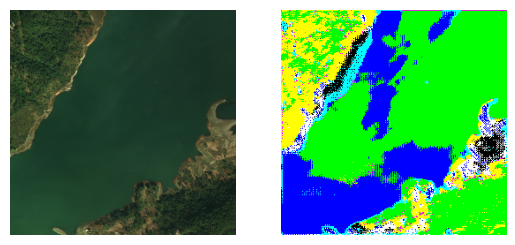

In [16]:
img = cv2.imread("E:\THIRD YEAR\Datasets\deepglobe/test/119896_sat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_tensor = image_transform(img)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_batch).squeeze()

_, predicted_labels = torch.max(output, 0)
predicted_mask = predicted_labels.squeeze().cpu().numpy()
print(torch.unique(predicted_labels))

label_map_colors = {0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for label, color in label_map_colors.items():
    colored_mask[predicted_mask == label] = color

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colored_mask)
plt.axis('off')

plt.show()

In [18]:
import os
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image

PREDICTION_SAVE_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\predictions"

def save_predictions_for_test_images(test_dir, model, transform, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for filename in os.listdir(test_dir):
        if filename.endswith('_sat.jpg'):
            img_path = os.path.join(test_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            input_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor).squeeze()
            _, predicted_labels = torch.max(output, 1)
            predicted_mask = predicted_labels.squeeze().cpu().numpy()

            colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
            for label, color in label_map_colors.items():
                colored_mask[predicted_mask == label] = color

            # Save masks
            base_filename = os.path.splitext(filename)[0]
            colored_mask_path = os.path.join(save_dir, f'{base_filename}_pred_colored_mask.png')
            raw_mask_path = os.path.join(save_dir, f'{base_filename}_pred_mask.npy')
            cv2.imwrite(colored_mask_path, cv2.cvtColor(colored_mask, cv2.COLOR_RGB2BGR))
            np.save(raw_mask_path, predicted_mask)

            print(f"Saved: {colored_mask_path} and {raw_mask_path}")

# Run this function to save predictions
save_predictions_for_test_images(TRAIN_DIR, model, image_transform, PREDICTION_SAVE_DIR)


Saved: E:\THIRD YEAR\Datasets\deepglobe\predictions\10233_sat_pred_colored_mask.png and E:\THIRD YEAR\Datasets\deepglobe\predictions\10233_sat_pred_mask.npy
Saved: E:\THIRD YEAR\Datasets\deepglobe\predictions\10452_sat_pred_colored_mask.png and E:\THIRD YEAR\Datasets\deepglobe\predictions\10452_sat_pred_mask.npy
Saved: E:\THIRD YEAR\Datasets\deepglobe\predictions\10901_sat_pred_colored_mask.png and E:\THIRD YEAR\Datasets\deepglobe\predictions\10901_sat_pred_mask.npy
Saved: E:\THIRD YEAR\Datasets\deepglobe\predictions\119_sat_pred_colored_mask.png and E:\THIRD YEAR\Datasets\deepglobe\predictions\119_sat_pred_mask.npy
Saved: E:\THIRD YEAR\Datasets\deepglobe\predictions\13415_sat_pred_colored_mask.png and E:\THIRD YEAR\Datasets\deepglobe\predictions\13415_sat_pred_mask.npy
Saved: E:\THIRD YEAR\Datasets\deepglobe\predictions\15573_sat_pred_colored_mask.png and E:\THIRD YEAR\Datasets\deepglobe\predictions\15573_sat_pred_mask.npy
Saved: E:\THIRD YEAR\Datasets\deepglobe\predictions\16453_sat_

In [20]:
# Matrix generation latest try
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the RGB to class mapping from the provided label map
rgb_to_class_map = {
    tuple(v): k for k, v in {
        0: [0, 255, 255],
        1: [255, 255, 0],
        2: [255, 0, 255],
        3: [0, 255, 0],
        4: [0, 0, 255],
        5: [255, 255, 255],
        6: [0, 0, 0]
    }.items()
}

def load_and_flatten(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image.flatten()  # Flatten to 1D array

def rgb_to_class(rgb_array, rgb_to_class_map):
    # Map RGB values to class labels
    return np.array([rgb_to_class_map.get(tuple(rgb_array[i:i+3]), -1) for i in range(0, len(rgb_array), 3)])

def generate_confusion_matrix(predicted_mask_path, true_mask_path, rgb_to_class_map):
    # Load and flatten the predicted and true masks
    pred_flat = load_and_flatten(predicted_mask_path)
    true_flat = load_and_flatten(true_mask_path)

    # Convert RGB values to class labels
    pred_labels = rgb_to_class(pred_flat, rgb_to_class_map)
    true_labels = rgb_to_class(true_flat, rgb_to_class_map)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels, labels=list(rgb_to_class_map.values()))
    return conf_matrix

# Paths to the predicted and true mask images
predicted_mask_path = 'E:/THIRD YEAR/Datasets/deepglobe/predictions/119_sat_pred_colored_mask.png'
true_mask_path = 'E:/THIRD YEAR/Datasets/deepglobe/sameSizeLessQTrain/119_mask.png'

# Generate the confusion matrix
conf_matrix = generate_confusion_matrix(predicted_mask_path, true_mask_path, rgb_to_class_map)

# Visualize the confusion matrix
labels = list(rgb_to_class_map.values())
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [5992704, 1792]

In [ ]:
print(f"Converted True Labels (class indices): {all_labels}")


In [ ]:
# This is the safe version not complete tho
# look at the block below for further stuff

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Define RGB to class label mapping
rgb_to_class_map = {
    (0, 255, 255): 0,  # Class 0
    (255, 255, 0): 1,  # Class 1
    (255, 0, 255): 2,  # Class 2
    (0, 255, 0): 3,    # Class 3
    (0, 0, 255): 4,    # Class 4
    (255, 255, 255): 5, # Class 5
    (0, 0, 0): 6       # Class 6
}

def resize_image(image, target_size):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)

def load_and_resize_masks(predicted_mask_path, true_mask_path, target_size=(256, 256)):
    pred_mask = cv2.imread(predicted_mask_path)
    true_mask = cv2.imread(true_mask_path)
    
    if pred_mask is None:
        raise FileNotFoundError(f"Predicted mask image not found at {predicted_mask_path}")
    if true_mask is None:
        raise FileNotFoundError(f"True mask image not found at {true_mask_path}")
    
    # Resize images to the same size
    pred_mask = resize_image(pred_mask, target_size)
    true_mask = resize_image(true_mask, target_size)
    
    return pred_mask, true_mask



def rgb_to_class(mask, rgb_to_class_map):
    if mask is None:
        raise ValueError("Input mask is None")
    
    h, w, _ = mask.shape
    class_map = np.zeros((h, w), dtype=np.int64)
    for rgb, label in rgb_to_class_map.items():
        class_map[np.all(mask == rgb, axis=-1)] = label
    return class_map


def generate_confusion_matrix(predicted_mask_path, true_mask_path, rgb_to_class_map, target_size=(256, 256)):
    # Load and resize masks
    pred_mask, true_mask = load_and_resize_masks(predicted_mask_path, true_mask_path, target_size)
    
    # Convert RGB masks to class labels
    pred_labels = rgb_to_class(pred_mask, rgb_to_class_map)
    true_labels = rgb_to_class(true_mask, rgb_to_class_map)
    
    # Flatten the arrays to 1D
    pred_flat = pred_labels.flatten()
    true_flat = true_labels.flatten()

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_flat, pred_flat, labels=list(rgb_to_class_map.values()))
    
    # Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(rgb_to_class_map.keys()), yticklabels=list(rgb_to_class_map.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return conf_matrix

# Paths to the predicted and true mask images
predicted_mask_path = 'E:/THIRD YEAR/Datasets/deepglobe/predictions/119_sat_pred_colored_mask.png'
true_mask_path = 'E:/THIRD YEAR/Datasets/deepglobe/sameSizeLessQTrain/119_mask.png'

# Generate the confusion matrix
conf_matrix = generate_confusion_matrix(predicted_mask_path, true_mask_path, rgb_to_class_map)

# Visualize the confusion matrix
labels = list(rgb_to_class_map.values())
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)

conf_matrix = generate_confusion_matrix(predicted_mask_path, true_mask_path, rgb_to_class_map)
print("Confusion Matrix:\n", conf_matrix)


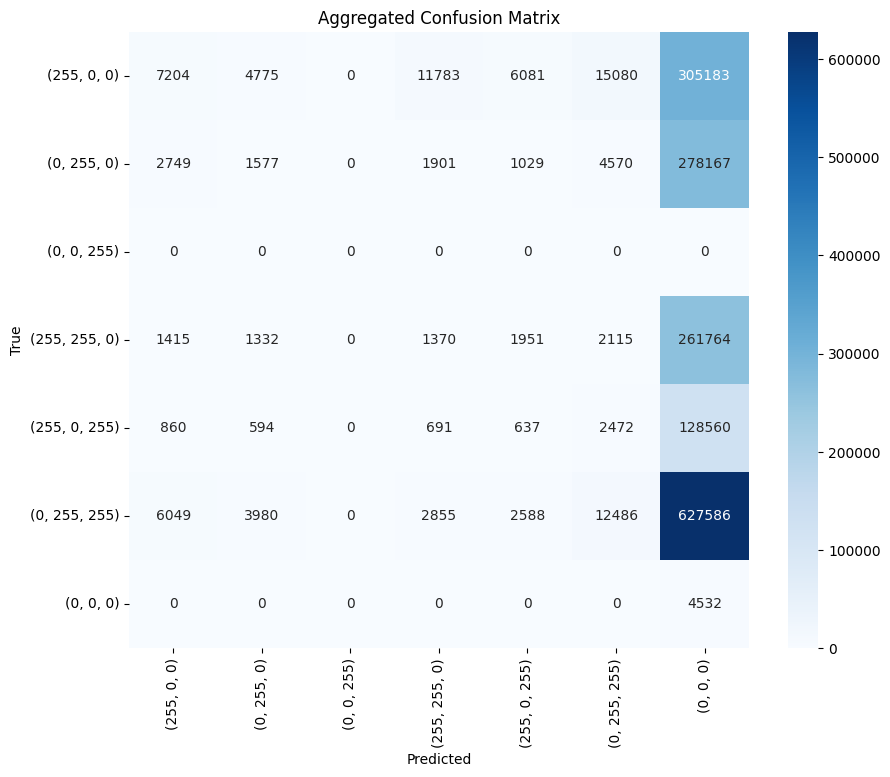

array([[  7204,   4775,      0,  11783,   6081,  15080, 305183],
       [  2749,   1577,      0,   1901,   1029,   4570, 278167],
       [     0,      0,      0,      0,      0,      0,      0],
       [  1415,   1332,      0,   1370,   1951,   2115, 261764],
       [   860,    594,      0,    691,    637,   2472, 128560],
       [  6049,   3980,      0,   2855,   2588,  12486, 627586],
       [     0,      0,      0,      0,      0,      0,   4532]],
      dtype=int64)

In [26]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the RGB to class label mapping
rgb_to_class_map = {
    (255, 0, 0): 0,    # Red -> Class 0
    (0, 255, 0): 1,    # Green -> Class 1
    (0, 0, 255): 2,    # Blue -> Class 2
    (255, 255, 0): 3,  # Yellow -> Class 3
    (255, 0, 255): 4,  # Magenta -> Class 4
    (0, 255, 255): 5,  # Cyan -> Class 5
    (0, 0, 0): 6       # Black -> Class 6
}

def resize_image(image, target_size):
    """Resize the image to the target size."""
    return cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)

def load_and_resize_masks(predicted_mask_path, true_mask_path, target_size=(256, 256)):
    """Load masks and resize them to the target size."""
    pred_mask = cv2.imread(predicted_mask_path)
    true_mask = cv2.imread(true_mask_path)
    
    if pred_mask is None:
        raise FileNotFoundError(f"Predicted mask image not found at {predicted_mask_path}")
    if true_mask is None:
        raise FileNotFoundError(f"True mask image not found at {true_mask_path}")
    
    # Resize images to the same size
    pred_mask = resize_image(pred_mask, target_size)
    true_mask = resize_image(true_mask, target_size)
    
    return pred_mask, true_mask

def rgb_to_class(mask, rgb_to_class_map):
    """Convert an RGB mask to class labels."""
    if mask is None:
        raise ValueError("Input mask is None")
    
    h, w, _ = mask.shape
    class_map = np.zeros((h, w), dtype=np.int64)
    for rgb, label in rgb_to_class_map.items():
        color_array = np.array(rgb)
        mask_condition = np.all(mask == color_array, axis=-1)
        class_map[mask_condition] = label
    return class_map

def aggregate_confusion_matrix(pred_mask_dir, true_mask_dir, rgb_to_class_map, target_size=(256, 256)):
    """Generate and visualize the aggregated confusion matrix for all images."""
    all_preds = []
    all_trues = []
    
    # Loop through all images in the directories
    for filename in os.listdir(pred_mask_dir):
        if filename.endswith('_sat_pred_colored_mask.png'):
            base_name = filename.replace('_sat_pred_colored_mask.png', '')
            pred_mask_path = os.path.join(pred_mask_dir, filename)
            true_mask_path = os.path.join(true_mask_dir, f"{base_name}_mask.png")
            
            try:
                # Load and resize masks
                pred_mask, true_mask = load_and_resize_masks(pred_mask_path, true_mask_path, target_size)
                
                # Convert RGB masks to class labels
                pred_labels = rgb_to_class(pred_mask, rgb_to_class_map)
                true_labels = rgb_to_class(true_mask, rgb_to_class_map)
                
                # Flatten the arrays to 1D
                pred_flat = pred_labels.flatten()
                true_flat = true_labels.flatten()
                
                all_preds.extend(pred_flat)
                all_trues.extend(true_flat)
            except FileNotFoundError as e:
                print(e)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_trues, all_preds, labels=list(rgb_to_class_map.values()))
    
    # Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(rgb_to_class_map.keys()), yticklabels=list(rgb_to_class_map.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Aggregated Confusion Matrix')
    plt.show()

    return conf_matrix

# Define directories
pred_mask_dir = 'E:/THIRD YEAR/Datasets/deepglobe/predictions'
true_mask_dir = 'E:/THIRD YEAR/Datasets/deepglobe/sameSizeLessQTrain'

# Execute the function to generate and visualize the aggregated confusion matrix
aggregate_confusion_matrix(pred_mask_dir, true_mask_dir, rgb_to_class_map)


In [44]:
print(np.unique(preds))


[6]


In [ ]:
# Trying another way
rgb_to_class_map = {
    (0, 255, 255): 0,    # Cyan -> Class 0
    (255, 255, 0): 1,    # Yellow -> Class 1
    (255, 0, 255): 2,    # Magenta -> Class 2
    (0, 255, 0): 3,      # Green -> Class 3
    (0, 0, 255): 4,      # Blue -> Class 4
    (255, 255, 255): 5,  # White -> Class 5
    (0, 0, 0): 6,        # Black -> Class 6
}

import numpy as np
import cv2
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to map an RGB pixel value to a class label
def rgb_to_label(pixel, rgb_to_class_map):
    pixel_tuple = tuple(pixel)
    return rgb_to_class_map.get(pixel_tuple, -1)  # -1 for unknown classes

# Function to read, flatten and map an image to label indices
def process_mask(mask_path, rgb_to_class_map):
    mask = cv2.imread(mask_path)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask_flat = mask_rgb.reshape(-1, 3)  # Flatten into (N, 3) for RGB comparison
    labels_flat = np.array([rgb_to_label(pixel, rgb_to_class_map) for pixel in mask_flat])
    return labels_flat

# Prepare confusion data by comparing predictions and true masks
def prepare_confusion_data(predictions_dir, labels_dir, rgb_to_class_map):
    preds = []
    true_labels = []
    
    prediction_files = [f for f in os.listdir(predictions_dir) if f.endswith('.png')]
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.png')]

    for pred_file in prediction_files:
        base_name = os.path.splitext(pred_file)[0]
        label_file = f"{base_name}.png"
        
        if label_file in label_files:
            pred_path = os.path.join(predictions_dir, pred_file)
            label_path = os.path.join(labels_dir, label_file)
            
            pred_labels = process_mask(pred_path, rgb_to_class_map)
            true_labels_ = process_mask(label_path, rgb_to_class_map)
            
            preds.extend(pred_labels)
            true_labels.extend(true_labels_)
    
    return np.array(preds), np.array(true_labels)


# Directories for your data
PREDICTIONS_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\sameSizeLessQTrain"
LABELS_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\sameSizeLessQTrain"

# Prepare confusion matrix data
preds, true_labels = prepare_confusion_data(PREDICTIONS_DIR, LABELS_DIR, rgb_to_class_map)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds, labels=list(rgb_to_class_map.values()))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(rgb_to_class_map.values()), yticklabels=list(rgb_to_class_map.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
